<h1> <center> Computational Project-2 </center><h1>

## Problem Statement
1. Find real data such that the values are positive. Suppose you model the data using a $Gamma(a,b)$ distribution. What is the method of moments (MoM) and maximum likelihood estimates (MLE) for the two parameters $a$ and $b$?

2. Now model the same data as a Normal distribution with an unknown mean and variance. Find the $95\%$ confidence interval for the variance parameter.

3. Collect real data for two relevant yet non-overlapping populations. If you model them as independent normal distributions with unknown means and variances, what will be the $95\%$  confidence interval for the difference in the means of the two populations?

4. Collect real data with binary response, which you can model as Bernoulli distributed data. Let p denote the probability of success defined here. Test for the $H_0: p \le \frac{1}{2} \quad \text{vs.} \quad H_1: p > \frac{1}{2}$. Comprehensively test the hypothesis at a level of significance of $0.05$.

In [3]:
#imports
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2, gamma, norm

from scipy.special import gammaln, digamma, polygamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt



In [4]:
#while using colab, uncomment the colab lines & upload the file to the database and comment the below(single) line

"""from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
frame = pd.read_csv(filename)"""

frame = pd.read_csv('Admission_Predict_Ver1.1.csv')


In [5]:
cgpa_data = frame['CGPA'].dropna() #removing rows with empty cgpa
n = len(cgpa_data)
sample_mean = cgpa_data.mean()
sample_var = cgpa_data.var(ddof=1)  #ddof 1 because we're taking sample variance so denominator n-1


The Gamma Distribution, parameterized with shape parameter($\alpha$) and scale parameter($\frac{1}{\beta}\Leftrightarrow \beta$ is rate parameter) is given by
$$
f(x; \alpha, \beta) = \frac{\beta^\alpha}{ \Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x} \;\;\; \text{for } x > 0, \alpha, \beta > 0  
\quad \quad \quad \quad \quad \quad \text{[As per "problem-set6.pdf"]}
$$  

where $\Gamma(\alpha)$ is the gamma function defined as
$$
\Gamma(\alpha) = \int_0^\infty t^{\alpha - 1} e^{-t} dt
$$

The gamma function is a generalization of the factorial function $ \ni \Gamma(n+1) = n\Gamma(n) =n!$  $\forall n \in \mathbb{N}$, with mean of distribution $\mu_{\Gamma} = \frac{\alpha}{\beta}$ & the variance $\sigma^2_{\Gamma} = \frac{\alpha}{\beta^2}$.

PS: Many places in texts, the distribution is parameterized with scale parameter(here $\frac{1}{\beta}$) as $\beta$, and is now called rate parameter (just a change of notation)  
$\;\;\;$  
Source: [Wikipedia](https://en.wikipedia.org/wiki/Gamma_distribution), [Scipy Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)   & [A Random Webpage](https://www.statisticshowto.com/gamma-distribution/)  
$\;\;\;$  
In the question, $\alpha = a$ and $\beta = b$.

In [6]:
#1st question

#Method of moments for gamma distribution: x_bar = a/b, s^2 = a/b^2

a_mom = sample_mean**2 / sample_var
b_mom = sample_mean / sample_var

print(f"MOM estimates: a = {a_mom:.3f}, b = {b_mom:.3f}")

"""a_mle, loc, scale_para_mle = gamma.fit(cgpa_data, floc=0)
b_mle = 1/scale_para_mle

print(f"MLE estimates: a = {a_mle:.3f}, b = {b_mle:.3f}")"""


MOM estimates: a = 201.082, b = 23.446


'a_mle, loc, scale_para_mle = gamma.fit(cgpa_data, floc=0)\nb_mle = 1/scale_para_mle\n\nprint(f"MLE estimates: a = {a_mle:.3f}, b = {b_mle:.3f}")'

In [7]:
# Using the Optimization method to find MLE estimates for a & b
"""
def neg_log_likelihood(params):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf  # log-likelihood is undefined for non-positive a or b
    log_lik = n * (a * np.log(b) - gammaln(a)) + (a - 1) * np.sum(np.log(cgpa_data)) - b * np.sum(cgpa_data)
    return -log_lik

result = minimize(neg_log_likelihood, x0=[a_mom, b_mom],  bounds=[(1e-5, None), (1e-5, None)])
a_mle, b_mle = result.x
print(f"MLE estimates using optimization: a = {a_mle:.3f}, b = {b_mle:.3f}")
"""


'\ndef neg_log_likelihood(params):\n    a, b = params\n    if a <= 0 or b <= 0:\n        return np.inf  # log-likelihood is undefined for non-positive a or b\n    log_lik = n * (a * np.log(b) - gammaln(a)) + (a - 1) * np.sum(np.log(cgpa_data)) - b * np.sum(cgpa_data)\n    return -log_lik\n\nresult = minimize(neg_log_likelihood, x0=[a_mom, b_mom],  bounds=[(1e-5, None), (1e-5, None)])\na_mle, b_mle = result.x\nprint(f"MLE estimates using optimization: a = {a_mle:.3f}, b = {b_mle:.3f}")\n'

For Stirling's Approzimation: [A Source](https://tminka.github.io/papers/minka-gamma.pdf)

In [8]:
# using sterling's approximation formula to calculate MLE for paramerters a & b
"""
log_mean = np.log(sample_mean)
mean_log = np.mean(np.log(cgpa_data))

a_mle = 0.5 /(log_mean-  mean_log )
b_mle = a_mle/sample_mean

print(f"MLE estimates using Sterling's approximation: a = {a_mle:.3f}, b = {b_mle:.3f}")
"""


'\nlog_mean = np.log(sample_mean)\nmean_log = np.mean(np.log(cgpa_data))\n\na_mle = 0.5 /(log_mean-  mean_log )\nb_mle = a_mle/sample_mean\n\nprint(f"MLE estimates using Sterling\'s approximation: a = {a_mle:.3f}, b = {b_mle:.3f}")\n'

In [9]:
# using Iterative method to calculate MLE for parameters a & b

mean_log = np.mean(np.log(cgpa_data))

# Initial guess
a = a_mom

# Newton-Raphson iteration
for _ in range(300):
    numerator = np.log(a) - digamma(a) - np.log(sample_mean) + mean_log
    denominator = 1 / a - polygamma(1, a)
    a -= numerator / denominator
    if abs(numerator) < 1e-8:
        break

a_mle = a
b_mle = a / sample_mean

print(f"MLE estimates using Iterative method: a = {a_mle:.3f}, b = {b_mle:.3f}")


MLE estimates using Iterative method: a = 200.169, b = 23.339


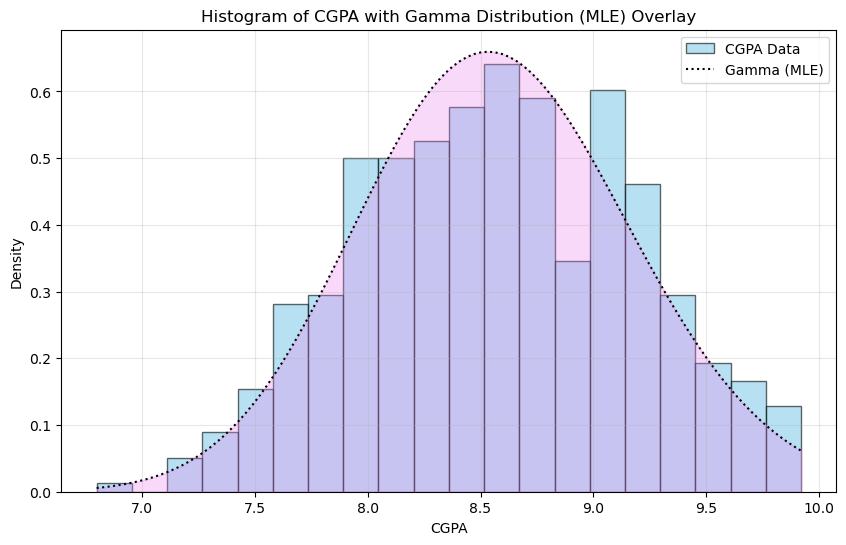

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(cgpa_data, bins=20, density=True, alpha=0.6, color='skyblue',edgecolor='black', label='CGPA Data')

#Gamma distribution with MLE parameters
x = np.linspace(cgpa_data.min(), cgpa_data.max(), 100)
y = stats.gamma.pdf(x, a=a_mle, scale=1/b_mle)
plt.plot(x, y, 'k:', label='Gamma (MLE)')
plt.fill_between(x, y, where=(x >= cgpa_data.min()) & (x <= cgpa_data.max()), color='violet', alpha=0.3)

plt.title('Histogram of CGPA with Gamma Distribution (MLE) Overlay')
plt.xlabel('CGPA')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
#2nd question

alpha = 0.05 #95% interval

chi2_lower = chi2.ppf(alpha / 2, df=n-1)
chi2_upper = chi2.ppf(1 - alpha / 2, df=n-1)

#confidence interval for variance
lower_bound = (n - 1) * sample_var / chi2_upper
upper_bound = (n - 1) * sample_var / chi2_lower

print(f"Sample Variance of CGPA: {sample_var:.3f}")
print(f"{100*(1-alpha):.0f}% Confidence Interval for Variance of CGPA: ({lower_bound:.2f}, {upper_bound:.2f})")


Sample Variance of CGPA: 0.366
95% Confidence Interval for Variance of CGPA: (0.32, 0.42)


In [12]:
#3rd question

# Provided lists
list1 = frame['TOEFL Score'].tolist()
list2 = frame['GRE Score'].tolist()

# Sample statistics
mean1, sample_var1, n = np.mean(list1), np.var(list1, ddof=1), len(list1)
mean2, sample_var2, m = np.mean(list2), np.var(list2, ddof=1), len(list2)

# Critical value for 95% confidence
alpha = 0.05

sp = np.sqrt(((n-1)*sample_var1 + (m-1)*sample_var2) / (n+m-2))
t_crit = stats.t.ppf(1-alpha/2, n+m-2)

ci_lower = (mean1 - mean2) - t_crit * sp * np.sqrt(1/n + 1/m)
ci_upper = (mean1 - mean2) + t_crit * sp * np.sqrt(1/n + 1/m)
print(f"{100*(1-alpha):.0f}% Confidence Interval for Difference of means is : ({ci_lower:.2f}, {ci_upper:.2f})")


95% Confidence Interval for Difference of means is : (-210.41, -208.15)


**Proof @ Q4**:
$$
\;\;\; \\
x_i \sim_{iid} Ber(p) \implies \mathbb{E}[x_i] = p \space \space \& \space \mathbb{V}ar[x_i] = p(1-p)
$$  
Sample space : $\{x_i | i \in \mathbb{N}^{\le \space n}\}$  

$$\bar{x} = \frac{\sum_{i=1}^{n} x_i}{n} \quad \implies \mathbb{E}[\bar{x}]=p \space \space \& 
\space \space
\mathbb{V}ar[\bar{x}]=\frac{p(1-p)}{n} \\ \frac{\bar{x}-p}{\sqrt{\frac{p(1-p)}{n}}} \sim \mathcal{N}(0, 1)
$$  
$\;\;\;$
for critical region(C): $\{\bar{x} - p > c\}$  
$\;\;\;$
$$
p(\text{type-1 error}) = \alpha \implies p(\text{reject $H_0(\in C)$ / $H_0$ is true})  \\
p_{H_0}(\bar{x}-p>c / p \le \frac{1}{2} ) = \alpha
$$
$\;\;\;$
to compare for the max case, we want to compare with $p_0 = \frac{1}{2}$ (simple one-sided test)  
$$
\implies p_{H_0}(\bar{x}-p_0>c) = \alpha \quad \quad \begin{bmatrix} \text{take}\space c = Z_{\alpha}\cdot\sqrt{\frac{p_0(1-p_0)}{n}}\end{bmatrix} $$  

by dividing with $\sqrt{\frac{p_0(1-p_0)}{n}}$ on both sides,

$$
\bar{x} -p_0 > Z_{\alpha}\cdot\sqrt{\frac{p_0(1-p_0)}{n}} \implies \text{reject $H_0$} \\  
\bar{x} -p_0 \le Z_{\alpha}\cdot\sqrt{\frac{p_0(1-p_0)}{n}} \implies \text{accept $H_0$}
$$


In [13]:
#4th question

def Hypothesis_testing(data, alpha=0.05, p_success=0.5):
    mean = data.mean()
    z_alpha = norm.ppf(1 - alpha)
    threshold = z_alpha * np.sqrt((p_success * (1 - p_success)) / len(data)) + p_success
    return mean > threshold


data_binary = frame['Research'].dropna()

data_binary = data_binary.sample(frac=1).reset_index(drop=True)

if Hypothesis_testing(data_binary):
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")


We reject the null hypothesis


A combined effort by
 - AI23BTECH11009 - [Pranav JVS](mailto:ai23btech11009@iith.ac.in)
 - AI23BTECH11024 - [Samagalla Sukesh Kumar](mailto:ai23btech11024@iith.ac.in)
 - AI23BTECH11017 - [Sai Kaushik P](mailto:AI23BTECH11017@iith.ac.in>)